## Installing Library

In [16]:
!pip install pynance yfinance

In [ ]:
# 1. Download the TA-Lib C library source code
! wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz

# 2. Extract the source code
! tar -xzvf ta-lib-0.4.0-src.tar.gz

# 3. Change directory into the extracted folder
%cd ta-lib

# 4. Configure, compile, and install the C library
! ./configure --prefix=/usr
! make
! make install

# 5. Change back to the parent directory
%cd ..

# 6. Install the Python wrapper for TA-Lib using pip
! pip install TA-Lib

# 7. Import and test the installation
import talib
print("TA-Lib imported successfully!")

--2025-11-27 06:58:37--  http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
Resolving prdownloads.sourceforge.net (prdownloads.sourceforge.net)... 104.18.13.149, 104.18.12.149, 2606:4700::6812:d95, ...
Connecting to prdownloads.sourceforge.net (prdownloads.sourceforge.net)|104.18.13.149|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz [following]
--2025-11-27 06:58:37--  http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving downloads.sourceforge.net (downloads.sourceforge.net)... 104.18.13.149, 104.18.12.149, 2606:4700::6812:d95, ...
Reusing existing connection to prdownloads.sourceforge.net:80.
HTTP request sent, awaiting response... 302 Found
Location: http://netactuate.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz?viasf=1 [following]
--2025-11-27 06:58:37--  http://netactuate.dl.

## Load Libraries

In [17]:
import pandas as pd
import numpy as np
import talib as ta
import matplotlib.pyplot as plt
import seaborn as sns
import pynance as pn
import yfinance as yf

## Load Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [18]:
import os

data_path = "/content/drive/MyDrive/Data/yfinance_data"

# List files to confirm
os.listdir(data_path)

['AAPL.csv', 'AMZN.csv', 'GOOG.csv', 'META.csv', 'MSFT.csv', 'NVDA.csv']

## Prepare Data

In [19]:
# List all files
files = ['AAPL.csv', 'AMZN.csv', 'GOOG.csv', 'META.csv', 'MSFT.csv', 'NVDA.csv']
all_data = []

In [20]:
for file in files:
    file_path = os.path.join(data_path, file)

    try:
        ticker = file.split('.')[0].upper()
        df = pd.read_csv(file_path)
        df['Ticker'] = ticker

        if 'Date' not in df.columns:
            print(f"Warning: 'Date' column not found in {file}. Skipping.")
            continue

        df['Date'] = pd.to_datetime(df['Date'])

        required_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
        for col in required_cols:
            if col not in df.columns:
                print(f"Warning: Required column '{col}' missing in {file}. Skipping.")
                break
            df[col] = pd.to_numeric(df[col], errors='coerce')
        else:
            all_data.append(df.dropna(subset=required_cols))

    except FileNotFoundError:
        print(f"❌ ERROR: File not found at path: {file_path}. Please check your FOLDER_PATH.")
        continue

if not all_data:
    print("\n--- ERROR: No data loaded. Please fix your FOLDER_PATH and re-run. ---")

else:
    df_combined = pd.concat(all_data, ignore_index=True)

    # 📌 FIX: Reset and explicitly set the MultiIndex names to prevent KeyError
    df_combined = df_combined.reset_index(drop=True)
    df_combined = df_combined.set_index(['Ticker', 'Date']).sort_index()

    print("Data loaded and combined successfully.")

Data loaded and combined successfully.


In [ ]:
df_combined.head()

Close      High       Low      Open      Volume
Ticker Date                                                          
AAPL   2009-01-02  2.721686  2.730385  2.554037  2.575630   746015200
       2009-01-05  2.836553  2.884539  2.780469  2.794266  1181608400
       2009-01-06  2.789767  2.914229  2.770872  2.877641  1289310400
       2009-01-07  2.729484  2.774170  2.706990  2.753477   753048800
       2009-01-08  2.780169  2.793666  2.700393  2.712090   673500800

## Analysis Indicators with TA-Lib

In [21]:

def calculate_indicators_with_talib(group):
        close = group['Close'].values
        high = group['High'].values
        low = group['Low'].values

        # 3.1 Simple Moving Average (SMA) - timeperiod=20
        group['SMA_20'] = talib.SMA(close, timeperiod=20)

        # 3.2 Relative Strength Index (RSI) - timeperiod=14
        group['RSI_14'] = talib.RSI(close, timeperiod=14)

        # 3.3 Moving Average Convergence Divergence (MACD)
        # Default TA-Lib parameters: fastperiod=12, slowperiod=26, signalperiod=9
        macd, macd_signal, macd_hist = talib.MACD(close,
                                                  fastperiod=12,
                                                  slowperiod=26,
                                                  signalperiod=9)
        group['MACD'] = macd
        group['MACD_Signal'] = macd_signal
        group['MACD_Hist'] = macd_hist

        return group

In [22]:
df_combined = df_combined.groupby('Ticker', group_keys=False).apply(calculate_indicators_with_talib)

In [23]:
def calculate_financial_metrics_with_pynance(group):
        close_series = group['Close']

        # Daily Returns: Calculated using pynance
        group['Daily_Return'] = pn.returns(close_series)

        # Cumulative Returns: Calculated using pynance
        # NOTE: If this fails, revert to (1 + group['Daily_Return']).cumprod() - 1
        group['Cumulative_Return'] = pn.cum_returns(close_series)

        # Volatility: Calculated using pynance (annualized by default or setting)
        # NOTE: If this fails, revert to group['Daily_Return'].rolling(20).std() * np.sqrt(252)
        group['Volatility_20d'] = pn.rolling_vol(close_series, window=20)

        return group

In [ ]:
def calculate_financial_metrics(group):
        # Daily Returns
        group['Daily_Return'] = group['Close'].pct_change()

        # Cumulative Returns
        group['Cumulative_Return'] = (1 + group['Daily_Return']).cumprod() - 1

        # Volatility (20-day rolling standard deviation of daily returns, annualized)
        group['Volatility_20d'] = group['Daily_Return'].rolling(window=20).std() * np.sqrt(252)

        return group

In [24]:
df_combined = df_combined.groupby('Ticker', group_keys=False).apply(calculate_financial_metrics)

Visualize

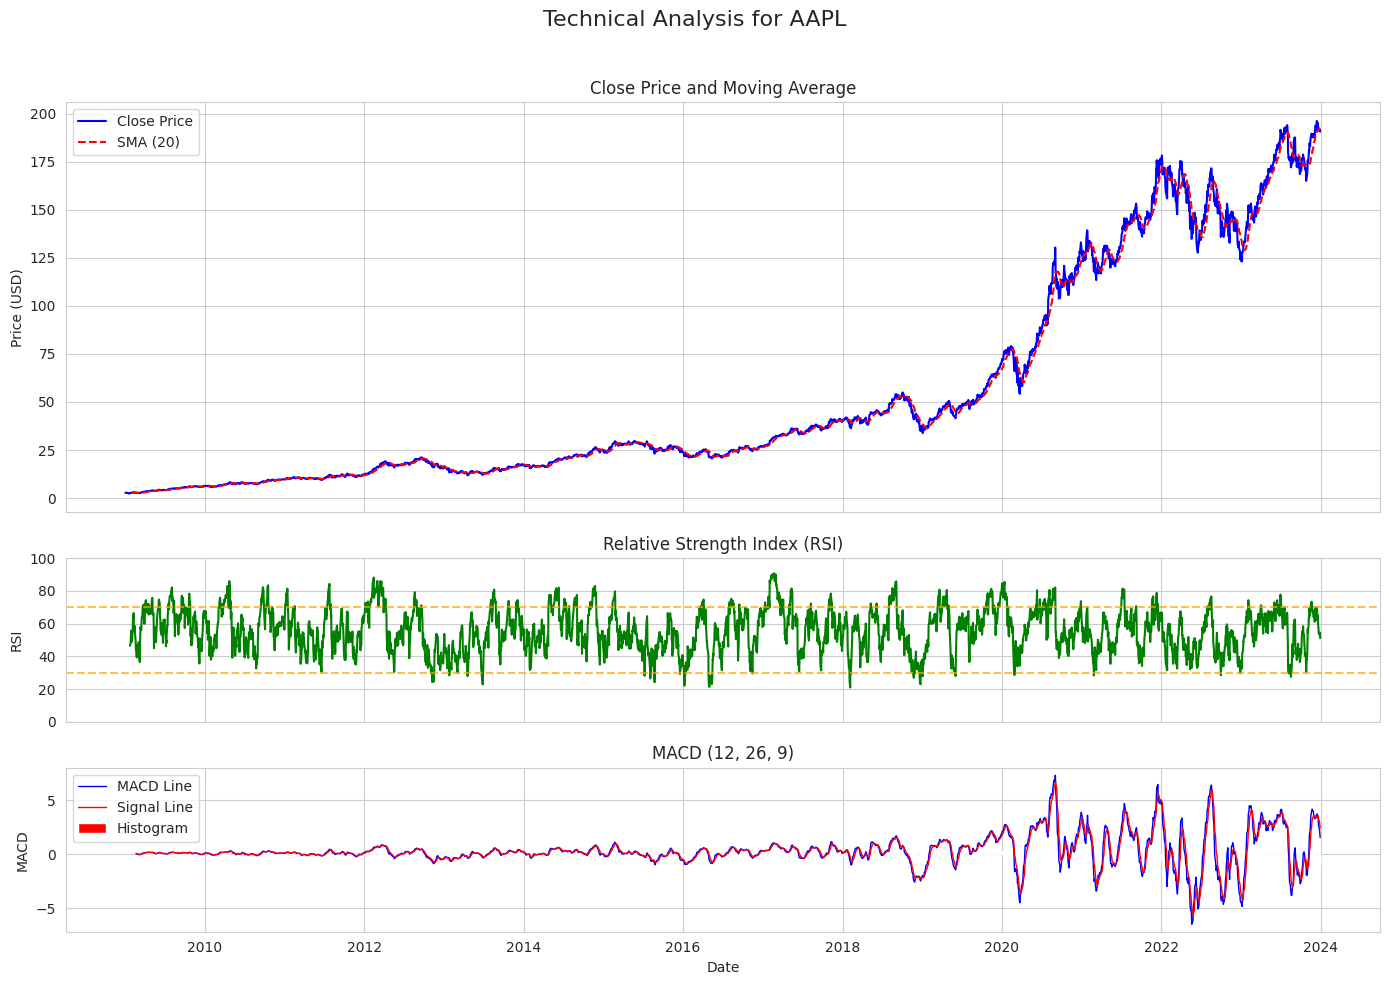


--- Execution Complete ---


In [25]:
first_ticker = None
try:
    aapl_df = df_combined.loc['AAPL'].copy()
    first_ticker = 'AAPL'
except KeyError:
    print("AAPL not found or index error. Using the first available Ticker.")
    first_ticker = df_combined.index.get_level_values('Ticker').unique()[0]
    aapl_df = df_combined.loc[first_ticker].copy()

# Ensure Date is in the index for plotting (since Ticker was removed by .loc)
aapl_df = aapl_df.reset_index(level='Date', drop=False).set_index('Date')

# MATPLOTLIB/SEABORN PLOTTING
sns.set_style("whitegrid")

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 10), sharex=True, gridspec_kw={'height_ratios': [2.5, 1, 1]})
fig.suptitle(f"Technical Analysis for {first_ticker}", fontsize=16)

# AXIS 1: Price and SMA
ax1.plot(aapl_df.index, aapl_df['Close'], label='Close Price', color='blue', linewidth=1.5)
ax1.plot(aapl_df.index, aapl_df['SMA_20'], label='SMA (20)', color='red', linestyle='--', linewidth=1.5)
ax1.set_ylabel('Price (USD)')
ax1.set_title('Close Price and Moving Average')
ax1.legend(loc='upper left')

# AXIS 2: RSI
ax2.plot(aapl_df.index, aapl_df['RSI_14'], label='RSI (14)', color='green', linewidth=1.5)
ax2.axhline(70, linestyle='--', color='orange', alpha=0.7)
ax2.axhline(30, linestyle='--', color='orange', alpha=0.7)
ax2.set_ylabel('RSI')
ax2.set_title('Relative Strength Index (RSI)')
ax2.set_ylim(0, 100)

# AXIS 3: MACD
macd_colors = np.where(aapl_df['MACD_Hist'] > 0, 'green', 'red')
ax3.bar(aapl_df.index, aapl_df['MACD_Hist'], label='Histogram', color=macd_colors, width=1)
ax3.plot(aapl_df.index, aapl_df['MACD'], label='MACD Line', color='blue', linewidth=1)
ax3.plot(aapl_df.index, aapl_df['MACD_Signal'], label='Signal Line', color='red', linewidth=1)
ax3.set_ylabel('MACD')
ax3.set_title('MACD (12, 26, 9)')
ax3.legend(loc='upper left')
ax3.set_xlabel('Date')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

print("\n--- Execution Complete ---")


--- 4. Generating and Displaying Matplotlib/Seaborn Visualization (All 6 Companies) ---
Plotting Close Prices...
Plotting Cumulative Returns...


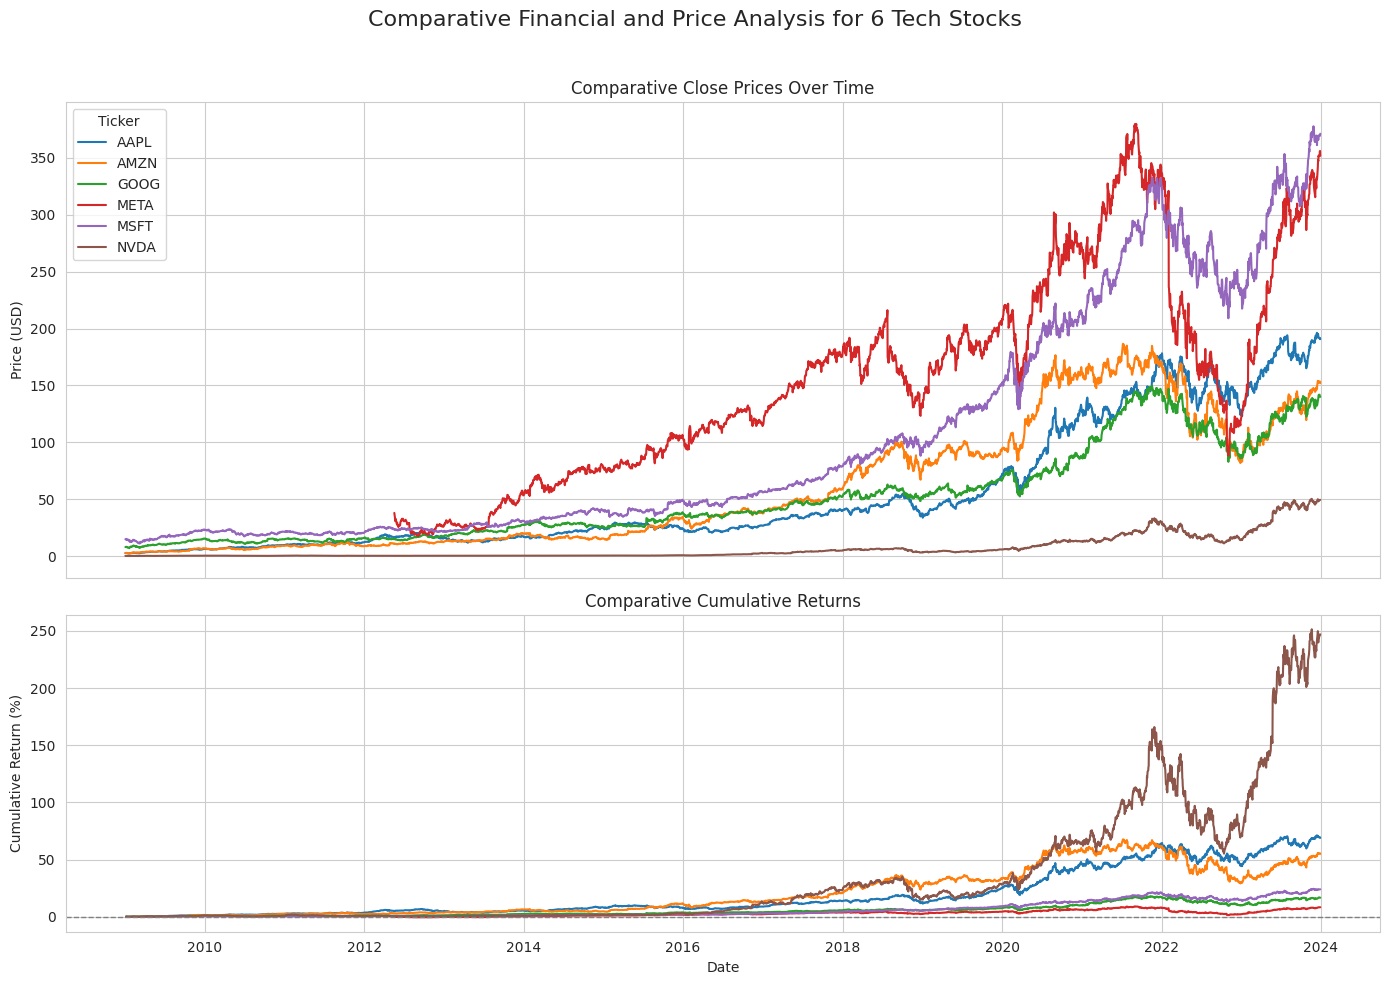


--- Execution Complete ---


In [26]:
    # --- 5. Visualize with Matplotlib/Seaborn (All 6 Companies) ---
    print("\n--- 4. Generating and Displaying Matplotlib/Seaborn Visualization (All 6 Companies) ---")

    # Ensure all data is ready for plotting. We'll use the entire df_combined.
    df_plot = df_combined.reset_index()

    # Get the list of all tickers
    all_tickers = df_plot['Ticker'].unique()

    # MATPLOTLIB/SEABORN PLOTTING
    sns.set_style("whitegrid")

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True, gridspec_kw={'height_ratios': [3, 2]})
    fig.suptitle(f"Comparative Financial and Price Analysis for {len(all_tickers)} Tech Stocks", fontsize=16)

    # --- AXIS 1: Comparative Close Prices ---
    print("Plotting Close Prices...")

    # Use Seaborn's lineplot for easy grouping by Ticker
    sns.lineplot(data=df_plot, x='Date', y='Close', hue='Ticker', ax=ax1, linewidth=1.5)

    ax1.set_title('Comparative Close Prices Over Time')
    ax1.set_ylabel('Price (USD)')
    ax1.legend(loc='upper left', title='Ticker')

    # --- AXIS 2: Comparative Cumulative Returns ---
    print("Plotting Cumulative Returns...")

    sns.lineplot(data=df_plot, x='Date', y='Cumulative_Return', hue='Ticker', ax=ax2, linewidth=1.5, legend=False)

    ax2.axhline(0, color='grey', linestyle='--', linewidth=1)
    ax2.set_title('Comparative Cumulative Returns')
    ax2.set_ylabel('Cumulative Return (%)')
    ax2.set_xlabel('Date')

    # --- Final Plot Display ---
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

    print("\n--- Execution Complete ---")